# Experiment 1.3: MLP with 3D bottleneck and curriculum learning

In [Experiment 1.2](ex-1.2-color-mlp-bottleneck.ipynb), we successfully trained an MLP autoencoder with a 2D bottleneck to represent bright, saturated colors in a structure resembling the color wheel. This worked because the primary variation in the data was hue, which naturally maps to a circle.

Now, let's introduce more complexity: **variations in brightness (value)**. A 2D bottleneck is likely insufficient to capture both hue and value cleanly. So, in this experiment, we will:
1.  **Increase the bottleneck dimension to 3D.**
2.  **Employ curriculum learning:** We'll start by training the model on just the bright hues (similar to Ex 1.2) to establish the color wheel structure, hopefully in the first two dimensions of the bottleneck. Then, we'll gradually introduce darker colors (lower value) in subsequent training phases.
3.  **Use regularization:** We'll add loss terms to encourage the model to keep the hue representation planar (in the first two dimensions) and to keep all points near a unit sphere.

The hypothesis is that the model will learn the color wheel in a 2D plane within the 3D bottleneck space during the initial phases. As darker colors are introduced, the regularization will encourage the model to represent the decreasing value by moving points *out* of that initial plane while preserving the hue structure.

## Model: MLP with 3D bottleneck

The model architecture is very similar to the previous experiment, but with a bottleneck layer size of 3 (increased from 2). We will *not* use explicit normalization in the `forward` pass this time; instead, we'll rely on regularization terms in the loss function during training to encourage points towards a unit sphere.

In [ ]:
from dataclasses import dataclass
import torch
import torch.nn as nn


class ColorMLP(nn.Module):
    def __init__(self, normalize_bottleneck=False):
        super().__init__()
        # RGB input (3D) → hidden layer → bottleneck → hidden layer → RGB output
        self.encoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            nn.Linear(16, 3),  # Our critical bottleneck!
        )

        self.decoder = nn.Sequential(
            nn.Linear(3, 16),
            nn.GELU(),
            nn.Linear(16, 3),
            nn.Sigmoid(),  # Keep RGB values in [0,1]
        )

        self.normalize = normalize_bottleneck

    def forward(self, x: torch.Tensor) -> tuple[torch.Tensor, torch.Tensor]:
        # Get our bottleneck representation
        bottleneck = self.encoder(x)

        # Optionally normalize to unit vectors (like nGPT)
        if self.normalize:
            norm = torch.norm(bottleneck, dim=1, keepdim=True)
            bottleneck = bottleneck / (norm + 1e-8)  # Avoid division by zero

        # Decode back to RGB
        output = self.decoder(bottleneck)
        return output, bottleneck

## Curriculum learning setup

We define a sequence of training phases, each with its own dataset, number of epochs, and regularization weights.

**The curriculum:**

| Phase | Training Data                                | Normalization | Planar Constraint |
| ----- | -------------------------------------------- | ------------- | ----------------- |
| 1     | Pure primary, secondary, and tertiary colors | Weak          | Strong            |
| 2     | "All" pure hues                              | Moderate      | Strong            |
| 3     | A few slightly darker tones                  | Moderate      | Weak              |
| 4     | More slightly darker tones                   | Strong        | Very Weak         |
| 5     | Many darker tones                            | Strong        | None              |

**Regularization terms:**

- **Normalization loss:** Penalizes latent vectors whose L2 norm deviates from 1.0. This encourages points to lie on the surface of a unit sphere.
- **Planar constraint loss:** Penalizes non-zero values in the 3rd dimension (`latents[:, 2]`) of the bottleneck. This encourages the representation to stay flat (primarily use the first two dimensions), especially in early phases.

We gradually decrease the planar constraint and increase the normalization constraint. The idea is to first firmly establish the 2D color wheel and then allow the model to use the third dimension for brightness while encouraging the overall structure to remain spherical.

**Learning rate schedule:**
To avoid disrupting the learned structure when transitioning between phases, we use a linear learning rate warmup at the beginning of each phase. The LR starts low and ramps up over the first 10% of the phase's epochs.


### Training implementation

Let's define the `CurriculumPhase` dataclass and the updated `train_color_model` function incorporating the curriculum logic, regularization losses, and LR scheduler.

In [ ]:
import numpy as np

from ex_color.data.color_cube import ColorCube
from ex_color.data.cyclic import arange_cyclic


@dataclass
class CurriculumPhase:
    name: str
    data: torch.Tensor
    epochs: int
    norm_loss_weight: float
    nonplanar_loss_weight: float


def train_color_model(model: ColorMLP, curriculum: list[CurriculumPhase], base_lr=0.001, warmup_fraction=0.1):
    from torch import optim
    from torch.optim.lr_scheduler import LinearLR
    from tqdm import tqdm

    # Create optimizer once for the entire training process
    optimizer = optim.Adam(model.parameters(), lr=base_lr)
    criterion = nn.MSELoss()

    # Store bottleneck values for visualization
    bottleneck_history = []

    total_epochs = sum(phase.epochs for phase in curriculum)

    with tqdm(total=total_epochs) as pbar:
        for phase in curriculum:
            warmup_epochs = max(1, int(phase.epochs * warmup_fraction))
            scheduler = LinearLR(
                optimizer,
                start_factor=1 / warmup_epochs,
                end_factor=1.0,
                total_iters=warmup_epochs,
            )

            for _ in range(phase.epochs):
                pbar.update(1)
                optimizer.zero_grad()

                # Forward pass
                outputs, latents = model(phase.data)

                # Reconstruction loss (main objective)
                recon_loss = criterion(outputs, phase.data)

                # Regularization losses

                # Penalize latents not being unit vectors
                norms = torch.norm(latents, dim=1)  # L2 norm of each latent
                norm_loss = torch.mean((norms - 1.0) ** 2)  # MSE to unit norm

                # Penalize non-planar latents (latents[:, 2] should be close to 0)
                nonplanar_loss = torch.mean(latents[:, 2] ** 2)  # Penalize non-planar latents

                loss = (
                    recon_loss
                    + phase.norm_loss_weight * norm_loss
                    + phase.nonplanar_loss_weight * nonplanar_loss
                )  # fmt: skip

                # Backward pass
                loss.backward()
                optimizer.step()
                scheduler.step()

                # current_lr = optimizer.param_groups[0]['lr']
                pbar.set_postfix(
                    phase=phase.name,
                    lr=f'{scheduler.get_last_lr()[0]:.6f}',
                    loss=f'{loss.item():.4f}',
                    recon=f'{recon_loss.item():.4f}',
                    norm=f'{norm_loss.item():.4f}',
                    nonplanar=f'{nonplanar_loss.item():.4f}',
                )

            with torch.no_grad():
                _, latents = model(phase.data)
                bottleneck_history.append(latents.clone())

    return bottleneck_history


# Create a model variant without explicit normalization
model = ColorMLP(normalize_bottleneck=False)

curriculum = [
    CurriculumPhase(
        name='Primary, secondary, tertiary',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=arange_cyclic(step_size=1 / 12),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        norm_loss_weight=0.02,
        nonplanar_loss_weight=0.1,
    ),
    CurriculumPhase(
        name='Bright hues only',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=arange_cyclic(step_size=1 / 360),
                s=np.array([1]),
                v=np.array([1]),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        norm_loss_weight=0.02,
        nonplanar_loss_weight=0.1,
    ),
    CurriculumPhase(
        name='Slightly darker hues',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=arange_cyclic(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.9, 1, 2),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=3000,
        norm_loss_weight=0.05,
        nonplanar_loss_weight=0.02,
    ),
    CurriculumPhase(
        name='Brightness levels extended',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=arange_cyclic(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.8, 1, 3),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=2000,
        norm_loss_weight=0.1,
        nonplanar_loss_weight=0.005,
    ),
    CurriculumPhase(
        name='All brightness levels',
        data=torch.tensor(
            ColorCube.from_hsv(
                h=arange_cyclic(step_size=1 / 360),
                s=np.array([1]),
                v=np.linspace(0.2, 1, 10),
            )
            .permute('svh')
            .rgb_grid.reshape(-1, 3),
            dtype=torch.float32,
        ),
        epochs=3000,
        norm_loss_weight=0.1,
        nonplanar_loss_weight=0.0,
    ),
]

# Train with regularization
history = train_color_model(model, curriculum, base_lr=0.01, warmup_fraction=0.1)

## Visualizing the bottleneck evolution

Training complete! Let's visualize the bottleneck state at the end of each curriculum phase. We expect to see the color wheel form in the first two dimensions during the early phases due to the planar constraint. As the constraint weakens and darker colors are added (later phases), we should see points appearing "inside" the main wheel in this 2D view. These inner points correspond to the darker colors, hopefully pushed along the 3rd dimension (which isn't shown in these plots).

(12, 3) (12, 3)
(360, 3) (360, 3)
(720, 3) (720, 3)
(1080, 3) (1080, 3)
(3600, 3) (3600, 3)


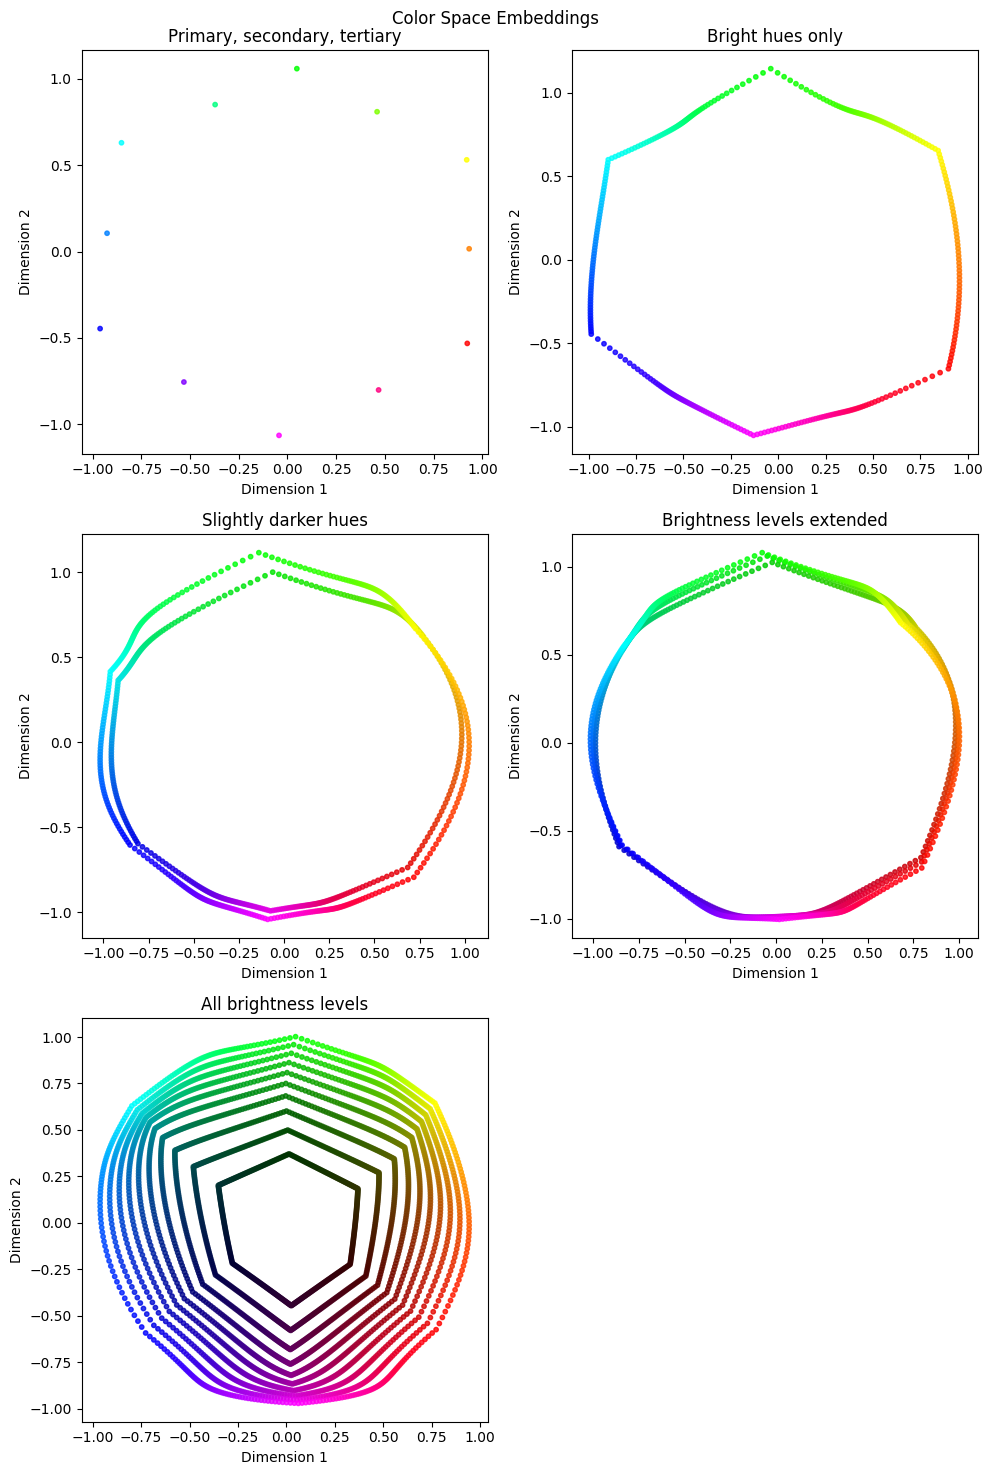

In [ ]:
import math
import matplotlib.pyplot as plt


# Create a scatter plot with points colored by their RGB values
nrows = math.ceil(len(curriculum) / 2)
fig, axes = plt.subplots(nrows, 2, figsize=(10, 5 * nrows))
axes = axes.flatten()

for phase, latents, ax in zip(curriculum, history, axes, strict=False):
    latents = latents.cpu().numpy()
    colors = phase.data.cpu().numpy().reshape(-1, 3)
    print(latents.shape, colors.shape)
    ax.scatter(latents[:, 0], latents[:, 1], c=colors, s=10, alpha=0.8)
    ax.set_title(phase.name)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')

# Hide any unused subplots
for ax in axes[len(curriculum) :]:
    ax.axis('off')

fig.suptitle('Color Space Embeddings')

plt.tight_layout()
plt.show()

The plot seems to confirm our hypothesis: The model learned the color wheel primarily in the plane of the first two dimensions, and as darker colors (lower value) were introduced, it represented them by moving points inwards *and* along the 3rd dimension. The final structure resembles a cone or dome, with the brightest colors forming the wide rim and darker colors converging towards the apex.

The curriculum and regularization successfully guided the model to learn a structured 3D representation that separates hue and value into different geometric features (angle vs. radius/height).

Next, we'll explore whether we can pin down those initial hue embeddings. It would be nice to be able to train on the tiny set of primary, secondary and tertiary colors, and then just know where they will be at the end of the training curriculum. Currently, they're allowed to drift, and we note that the final shape of the latent space is very sensitive to the hyperparmaeters of the curriculum (e.g. regularization weights).